In [1]:
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
import sys
import torch
import pandas as pd
sys.path.append("./Utils")
from utils import get_padded_loaders, load_checkpoint
sys.path.append('./Models')

In [2]:
path_train = "../Data/dataset_DRIVE/training/images/"
training_images = os.listdir(path_train)

In [3]:
train_images = {}
for i in sorted(training_images):
    number = i[0:2]
    img = np.array(PIL.Image.open(f'{path_train}{i}').convert("RGB"))
    train_images[str(number)] =  img

In [4]:
train_images['21'].shape

(584, 565, 3)

In [5]:
#Procesado de los labels

In [6]:
path_labels = "../Data/dataset_DRIVE/training/1st_manual/"
training_labels = os.listdir(path_labels)
labels = {}
for image in training_labels:
    img = np.array(PIL.Image.open(f'{path_labels}{image}').convert("L"), dtype=np.float32)
    labels[image[0:2]] = img

Text(0.5, 1.0, '21')

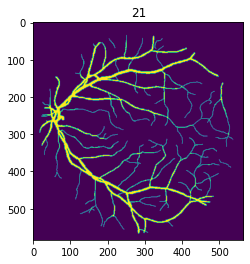

In [8]:
plt.imshow(labels['21'])
plt.title('21')

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Training Loader params

kwargs = {'train_dir': '../Data/dataset_DRIVE/training/images',
          'train_maskdir': '../Data/dataset_DRIVE/training/1st_manual',
          'val_dir': '../Data/dataset_DRIVE/validation/images',
          'val_maskdir': '../Data/dataset_DRIVE/validation/1st_manual',
          'batch_size': 3,
          'rotation': [-45, 45],
          'hflip_prob': 0.3,
          'brightness': [0.5, 1.5],
          'contrast': [0.5, 1.5],
          'gamma': [0.7, 1.3],
          'affine_prob': 0.4,
          'affine_translate': [0.05, 0.1],  # Horiz and vert translation
          'affine_scale': [1, 1.3],
          'affine_shears': [0, 0],
          'noise': (0, 0.2),  # (Mean,std)
          'num_workers': 0,
          'pin_memory': True}

In [72]:
train_loader, val_loader = get_padded_loaders(**kwargs)

Feature batch shape: torch.Size([3, 3, 576, 576])
Labels batch shape: torch.Size([3, 576, 576])
The Train image numbers present in the batch are: ('34', '33', '39')


Text(0.5, 1.0, '34')

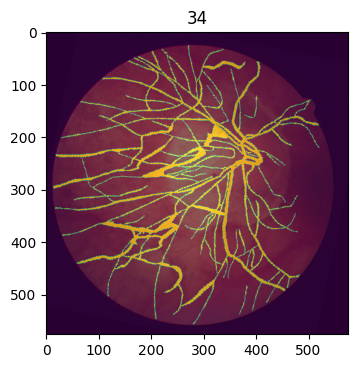

In [73]:
train_features, train_labels, numbers = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(f"The Train image numbers present in the batch are: {numbers}")
img = train_features[0].squeeze()
label = train_labels[0]
number = numbers[0]
plt.imshow(label, alpha=1)
plt.imshow(img.permute(1, 2, 0) , alpha=0.4)
plt.title(number)

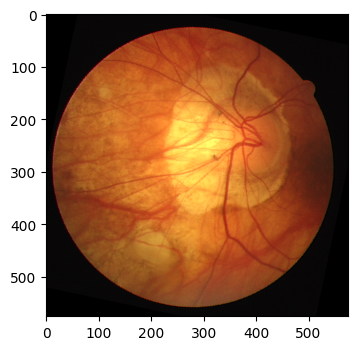

In [75]:
plt.imshow(img.permute(1, 2, 0) , alpha=1)

# Model 

In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
checks1 = "./Checkpoints_Swin_Unet/2022_04_12_4/training_logs.pt"
checks2 = "./Checkpoints_Swin_Unet/2022_04_13_1/training_logs.pt"
checks3 = "./Checkpoints_Swin_Unet/2022_04_18_1/training_logs.pt"
checks4 = "./Checkpoints_Swin_Unet/2022_04_18_2/training_logs.pt"
params1 = "./Checkpoints_Swin_Unet/2022_04_12_4/training_params.pt"
params2 = "./Checkpoints_Swin_Unet/2022_04_13_1/training_params.pt"
params3 = "./Checkpoints_Swin_Unet/2022_04_18_1/training_params.pt"
params4 = "./Checkpoints_Swin_Unet/2022_04_18_2/training_params.pt"

In [9]:
parametros1 = torch.load(params1)
parametros2 = torch.load(params2)
parametros3 = torch.load(params3)
parametros4 = torch.load(params4)

In [81]:
logs1 = torch.load(checks1)
logs2 = torch.load(checks2)
logs3 = torch.load(checks3)
logs4 = torch.load(checks4)

In [82]:
df = pd.DataFrame({"Config1_pretrained":logs1["dice"], "Config1":logs2["dice"], "Config2_pretrained":logs3["dice"], "Config2":logs4["dice"]})

In [83]:
plot = df.groupby(df.index // 4).mean()

In [84]:
smoothed = plot.groupby(plot.index // 50).mean()

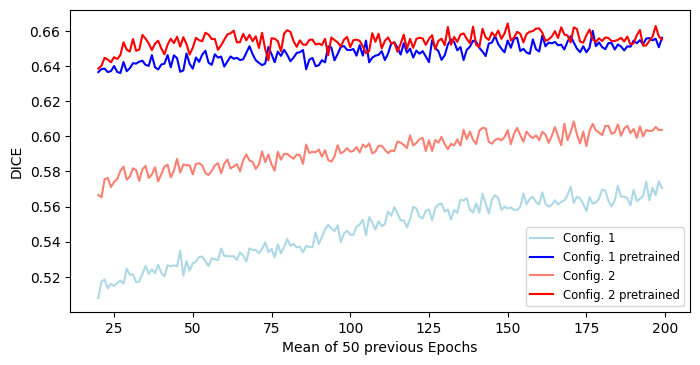

In [85]:
plt.rcParams["figure.figsize"] = [8,4]
plt.rcParams["figure.dpi"] = 100
plt.plot(smoothed.Config1[20:], c = "lightblue", label="Config. 1")
plt.xlabel('Mean of 50 previous Epochs')
plt.ylabel("DICE")
plt.plot(smoothed.Config1_pretrained[20:], c = "b", label="Config. 1 pretrained")
plt.plot(smoothed.Config2[20:], c = "salmon", label="Config. 2")
plt.plot(smoothed.Config2_pretrained[20:], c = "r", label="Config. 2 pretrained")
plt.legend(fontsize="small")

In [7]:
checks = "./Checkpoints_Swin_Unet/2022_04_19_2/training_logs.pt"
params = "./Checkpoints_Swin_Unet/2022_04_19_2/training_params.pt"
parametros = torch.load(params)
logs = torch.load(checks)
print(logs["best_accuracy"])
print(logs["best_dice"])
print(logs["best_auc"])

0.9587718822337963
0.7556849000917949
0.9203747733823971


# Generate images for Swin-Unet

In [8]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
from torchvision.transforms import ToTensor
from PIL import Image, ImageOps
import torchvision
from Swin_Unet import SwinTransformerSys
day_and_run = "2022_04_19_2"

In [9]:
model = SwinTransformerSys(img_size=576, embed_dim=96, in_chans = 3, num_classes=1, patch_size=4,
                           depths=[2, 2, 2, 2], depths_decoder=[1, 2, 2, 2], num_heads=[3, 6, 12, 24],
                           window_size=18, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                           drop_rate=0, attn_drop_rate=0., drop_path_rate=0.1,
                           norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                           use_checkpoint=False, final_upsample="expand_first").to(DEVICE)

SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1


/Users/alberto/anaconda3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---final upsample expand_first---


In [10]:

weights = weights = f"./Checkpoints_Swin_Unet/{day_and_run}/my_check.pth.tar"
load_checkpoint(torch.load(weights, map_location=torch.device(DEVICE)),
    model)
model.eval()

 => Loading checkpoint 


SwinTransformerSys(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(144, 144), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=96, input_resolution=(144, 144), num_heads=3, window_size=18, shift_size=0, mlp_ratio=4.0
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=96, window_size=(18, 18), num_heads=3
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): L

In [11]:
class DRIVE_dataset_padding (Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def transform_test(self, image):
        # Padding
        image = TF.pad(image, (5, 0, 6, 0), padding_mode="constant", fill=0) #left, top, right and bottom
        # Cropping
        image = ImageOps.crop(image, (0, 4, 0, 4))
        # Transform to tensor
        tens = ToTensor()
        image = tens(image)
        return image

    def __getitem__(self, index):

        number = self.images[index][0:2]
        image = f'{number}_test.tif'

        img_path = os.path.join(self.image_dir, image)

        img = Image.open(img_path).convert("RGB")

        # Fuerzo a 3 canales aunque solo sea uno para poder
        # aplicarle las mismas transformaciones
        img = self.transform_test(img)

        # Devuelvo solo 1 canal del label
        return img, number

def get_padded_loaders(
    test_dir,
    batch_size,
    num_workers,
    pin_memory
):

    test_ds = DRIVE_dataset_padding(
        image_dir=test_dir
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return test_loader

In [12]:
TEST_IMG_DIR = "../Data/dataset_DRIVE/test/images"
test_loader = get_padded_loaders(TEST_IMG_DIR, 20, 0, True)

In [63]:
if not os.path.exists(f"../Data/dataset_DRIVE/submit_Swin_Unet/{day_and_run}"):
    os.makedirs(f"../Data/dataset_DRIVE/submit_Swin_Unet/{day_and_run}")
for i in test_loader:
    image = i[0].to(device=DEVICE)
    with torch.no_grad():
        preds = torch.sigmoid(model(image))
        preds = (preds > 0.5).float()
        preds = TF.pad(preds, (0, 4, 0, 4), padding_mode="constant", fill=0)
        preds = preds[:, :, :, 5:570]
        torchvision.utils.save_image(
                preds, f"../Data/dataset_DRIVE/submit_Swin_Unet/{day_and_run}/{i[1][0]}"+".png")


In [18]:
problematic = next(iter(test_loader))[0][2]

In [19]:
problematic.shape

torch.Size([3, 576, 576])

In [20]:
problematic = problematic.unsqueeze(0)
x = problematic.to(device=DEVICE)
with torch.no_grad():
    preds = torch.sigmoid(model(x))
    preds = (preds > 0.5).float()

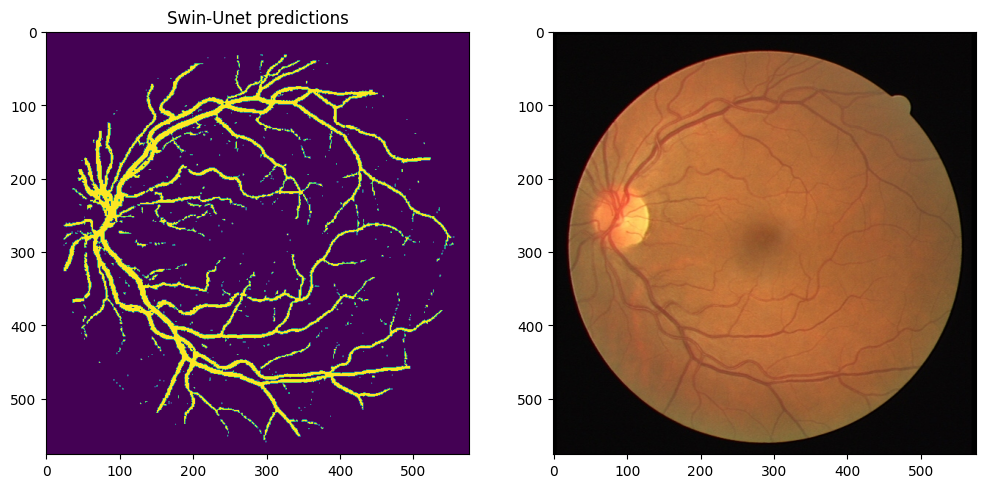

In [21]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.dpi"] = 100
fig, ax = plt.subplots(1,2)
ax[0].imshow(preds.squeeze(0).squeeze(0))
ax[0].set_title("Swin-Unet predictions")
ax[1].imshow(problematic.squeeze(0).permute(1, 2, 0))